In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
train_X, test_X = [], []
train_Y, test_Y = [], []
# 匯入training、testing data
for i in range(1,41):
    for j in range(1,11):
        name = str(i) + "_" + str(j) + ".png"
        
        if j == 10:    
            test = [cv2.imread("p1_data/" + name , cv2.IMREAD_GRAYSCALE)]     # 將圖片轉成灰階的格式資料形式讀取
            test_X.append(test)
        else:
            train = [cv2.imread("p1_data/" + name , cv2.IMREAD_GRAYSCALE)]
            train_X.append(train)
        
            train_Y.append(i) 
    test_Y.append(i)     # 紀錄第幾組照片(驗證時的"真實值")
    
train_X= np.array(train_X).reshape(360, 56*46)     # 將原本的照片pixel(56*46)拉直
test_X = np.array(test_X).reshape(40, 56*46)
print(train_X.shape)
print(test_X.shape)

(360, 2576)
(40, 2576)


## 第一題

(2576,)


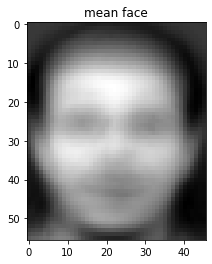

In [3]:
#(56*46) - (360*2576) - (2576,) - (56*46) 把360張照片拉直取平均特徵，在弄成一張照片

mean_vector = train_X.mean(axis = 0)   # 計算縱行算術平均數
print(mean_vector.shape)
plt.title("mean face")
plt.imshow(mean_vector.reshape(56,46), cmap='gray')   # 以灰階呈現
plt.show()

(360, 2576)


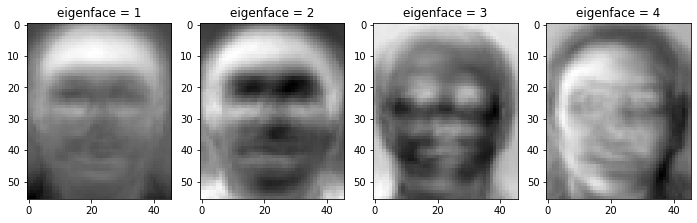

In [4]:
pca = PCA()                                  # 呼叫PCA函式
pca_train = pca.fit(train_X - mean_vector)      # 將正則化的訓練資料，做PCA訓練
print(pca_train.components_.shape)
plt.figure(figsize=(15,10))
for i in range(4):
    plt.subplot(1,5,i+1)
    plt.title("eigenface = " + str(i+1))
    plt.imshow(pca_train.components_[i].reshape(56,46), cmap='gray')  
plt.show()

## 第二題、第三題

(56, 46)
(1, 2576)
(1, 360)
(1, 2576)


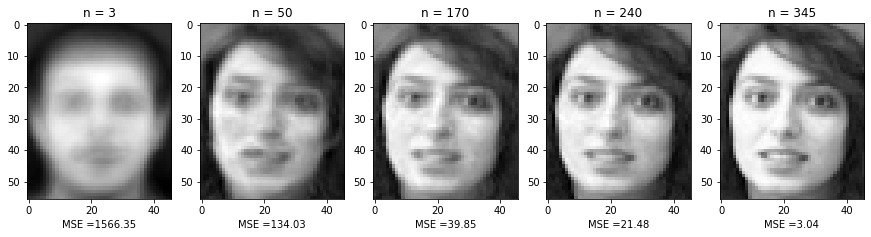

In [5]:
input = cv2.imread("p1_data/" + "8_1.png" , cv2.IMREAD_GRAYSCALE)   # 學號尾數偶數，使用 8_1圖
print(input.shape)
input = input.reshape(1,56*46)     # 把照片拉直
print(input.shape)

pca_test = pca.transform(input - mean_vector)    # PCA 訓練好後，皆可用 transform 降維
print(pca_test.shape)     # 從 1*2576 降到 1*360

n = [3, 50, 170, 240, 345]
plt.figure(figsize=(15,10))
for i,j in enumerate(n):     # i = [0, 1, 2, 3, 4] 、 j = [3, 50, 170, 240, 345]
    pca_red = np.dot(pca_test[: , :j] , pca_train.components_[:j ,:]) + mean_vector     # 還原原圖
    mse = np.mean((pca_red - input)**2)     # 計算 MSE
    
    plt.subplot(1,5,i+1)
    plt.title("n = "+str(j))
    plt.xlabel('MSE ='+str(round(mse,2)))
    plt.imshow(pca_red.reshape(56,46), cmap = "gray")
print(pca_red.shape)
plt.show()

## 第四題

In [6]:
knn = KNeighborsClassifier()            # 呼叫 KNN
param ={"n_neighbors" : [1 ,3 ,5]}
num_n = [3 ,50 , 170]
red_X = pca.transform(train_X - mean_vector)   # 訓練資料降維

# Cross Validation 統計準確率的平均數/標準差 (使用的優化器, 給定參數字典, 分割成幾分fold)
clf = GridSearchCV(knn , param_grid = param , cv = 3)   
best_k = 0
best_n = 0
best_res = float("-inf")     # 給定初始值 -∞
for n in num_n:
    clf.fit(red_X[:,:n] , train_Y)     # 給定 GridSearchCV需要的資料 
    for i in range(3):
        res = clf.cv_results_['mean_test_score'][i]   # 透過cv_results獲到分數，存入矩陣中(3次平均)
        if res > best_res :                           # 透過獲得的分數判斷好壞
            best_res , best_k , best_n = res , (i*2)+1 , n
        print("k = ",  (i*2)+1, ", n = ", n, "result = ", round(res,3))
    #print(clf.cv_results_['mean_test_score'])
print("Best result = ", round(best_res,3))            
print("Best k =", best_k)
print("Best n =", best_n)


k =  1 , n =  3 result =  0.65
k =  3 , n =  3 result =  0.611
k =  5 , n =  3 result =  0.561
k =  1 , n =  50 result =  0.961
k =  3 , n =  50 result =  0.9
k =  5 , n =  50 result =  0.847
k =  1 , n =  170 result =  0.956
k =  3 , n =  170 result =  0.889
k =  5 , n =  170 result =  0.822
Best result =  0.961
Best k = 1
Best n = 50


## 第五題

In [7]:
knn = KNeighborsClassifier(best_k)
knn.fit(red_X[:,:best_n] , train_Y)    # 給定 knn需要的資料
print(red_X[:,:best_n].shape)
red_test_X = pca.transform(test_X - mean_vector)     # PAC降維testing data
pred = knn.predict(red_test_X[:,:best_n])     # knn影像預測
print("Accuracy : " ,accuracy_score(y_pred = pred, y_true = test_Y))
print(pred,"\n",test_Y)

(360, 50)
Accuracy :  0.925
[ 1  2  3  4 40  6  7  8  9 38 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 16 36 37 38 39 40] 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
